<a href="https://colab.research.google.com/github/KatyaAB-125/primerRepo/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de fraude

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving creditcard.csv to creditcard.csv
User uploaded file "creditcard.csv" with length 150828752 bytes


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from scipy.stats import norm

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_auc_score
from xgboost import XGBClassifier

In [4]:
inputData = pd.read_csv('creditcard.csv')
inputData

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Análisis preliminar

In [5]:
print(inputData.shape[0],'transacciones.')

284807 transacciones.


In [6]:
print(inputData.shape[1],'variables.')

31 variables.


Llama la atención que el conjunto de datos es bastante opaco. De sus 31 variables, solo 3 son verdaderamente identificables, estando el resto probablemente transformadas. Aunque no es estrictamente necesario que sepamos con exactitud qué variables manejamos, en general, cuanto mejor conozcamos nuestra población muestral, más capacitados estaremos para identificar variables o factores de confusión e información superflua (que pese a no ser necesaria sí puede introducir sesgos).

Pongamos que, hipotéticamente, la variable V13 corresponde a la transformación del parámetro "color de la tarjeta de crédito con la que se realizó la transacción". Pongamos que, por pura casualidad, durante los dos días recogidos en la muestra, se realizaron muchísimas más transacciones con tarjetas de crédito azules, y que todas esas transacciones fueran genuinas/válidas. Si no eliminamos esta variable, nuestro modelo podría aprender que las operaciones realizadas con una tarjeta de color azul tienen una alta probabilidad de ser genuinas. Esta información es invisible a cualquier modelo estadístico que utilicemos, e introduce un sesgo que restará capacidad predictiva al modelo una vez se use en datos diferentes del training set.

Volviendo al dataset, entre las 3 varibles que sí podemos identificar tenemos: el tiempo (en segundos), la cantidad de dinero que se maneja en la transacción, y la clase de la misma. Es esta última variable, la única de carácter binario, la que nos informa acerca de si cada transacción es fraudulenta (class = 1) o genuina (class = 0). Vamos pues a comprobar cuántas operaciones fraudulentas se detectaron y a qué porcentaje del total corresponden, ya que esto será determinante para elegir el camino a seguir:

In [7]:
fraudTransactions = inputData.loc[inputData.Class == 1, 'Class'].count()
genTransactions = inputData.loc[inputData.Class == 0, 'Class'].count()
fraudPercentage = fraudTransactions/(fraudTransactions + genTransactions)*100
print('Hay un total de', fraudTransactions, 'transacciones fraudulentas, que corresponden a un', round(fraudPercentage, 4),'% del total.')

Hay un total de 492 transacciones fraudulentas, que corresponden a un 0.1727 % del total.


Podemos comprobar que de las 280807 transacciones que tenemos en el dataset, solo 492 son en realidad fraudulentas. Queremos entrenar un clasificador que prediga qué operaciones son fraudulentas pero solo tenemos un 0,17% de casos positivos en nuesto universo muestral, mucho menos del 1%. Tenemos una población profundamente desequilibrada, algo que queda todavía más claro si representamos esta distribución:

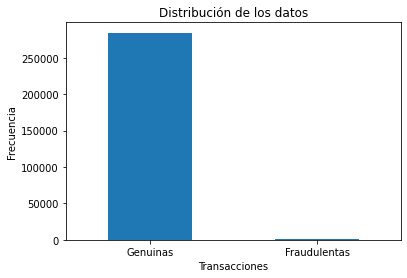

In [8]:
transAmount = pd.value_counts(inputData['Class'], sort = True)
transAmount.plot(kind = 'bar', rot = 0)
plt.title("Distribución de los datos")
plt.xticks(range(2), ['Genuinas', 'Fraudulentas'])
plt.xlabel("Transacciones")
plt.ylabel("Frecuencia")
plt.show()

Tenemos una cantidad de casos positivos absurdamente pequeña en relación al tamaño muestral.

Antes de tomar más decisiones, comprobemos si alguna de las variables es función de otras. Es decir, si existe correlación entre ellas. Vamos con esto:

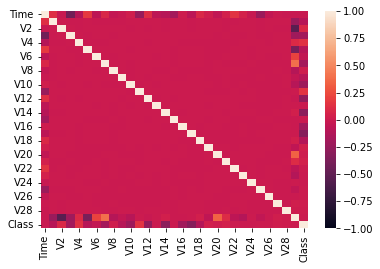

In [9]:
sb.heatmap(inputData.corr(), vmin=-1)
plt.show()

En el heatmap podemos ver que las variables cuya naturaleza no conocemos (las Vs) no tienen correlación entre sí:  no podemos predecir el valor de cualquiera de ellas en función del valor de las demás. Por tanto, no podemos eliminar ninguna del modelo en esta fase.

Sin embargo, en el caso de Time y Amount (que no aparece etiquetada en el heatmap, pero quedaría inmediatamente a la izquierda de Class), sí que observamos una ligera correlación con algunas de las variables V. Esto es especialmente evidente para la relación entre Amount y V2 (correlación negativa). El hecho de estar fuertemente correlacionada con V2 y ligeramente con el resto, nos da pie a plantearnos eliminar la variable Amount de nuestro modelo. Probablemente no perderíamos poder de predicción, ya que el peso que pudiera tener queda incluido en V2 y las demás variables. 

En el caso del Time, la correlación con otras variables es más débil, pero podemos tenerla en cuenta por si algún otro factor nos invita a eliminarla.

Vamos a comprobar también la distribución de cada variable individual. Esto es, si siguen una distribución normal o no. Además de ser un paso adicional para entender mejor la muestra, esto puede ayudar a seleccionar un modelo estadístico u otro:

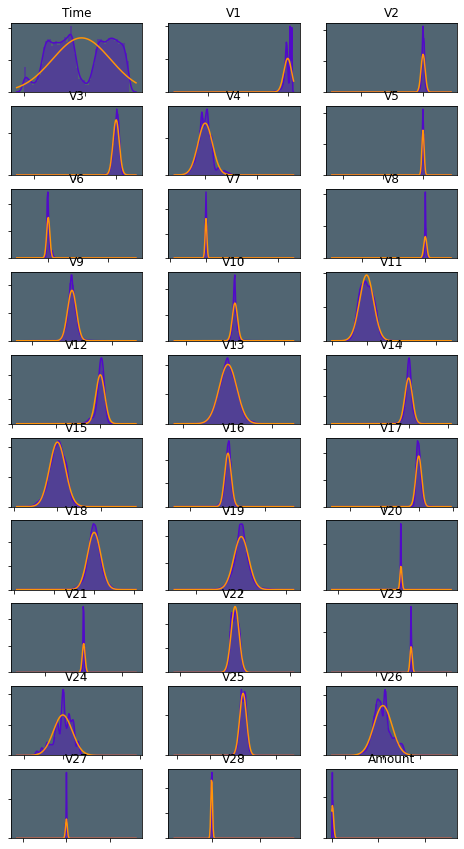

In [12]:
# Este import sirve para que no se llene la celda con warnings acerca de que la función que uso, distplot, dejará
# de funcionar en próximas versiones de Python
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

figures, axes = plt.subplots(10, 3, squeeze = False)
for i, ax in enumerate(axes.flatten()):
    ax.set_facecolor('xkcd:slate')
    ax.set_title(inputData.columns[i])
    sb.distplot(inputData.iloc[:, i], ax = ax, fit = norm, color = 'xkcd:violet blue', fit_kws = {'color': 'xkcd:tangerine'})
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels('')
    ax.set_yticklabels('')
figures.set_size_inches(8, 15)
plt.show()

En las gráficas se pueden observar, en morado, la distribución de cada variable, y en naranja, la distribución normal real. Podemos comprobar que todas las variables menos Time siguen una distribución normal, aunque con algunos valores outlier. 

Esta observación haría posible usar un modelo gaussiano multivariante si eliminamos la variable tiempo del modelo. Un modelo gaussiano, como su nombre indica, trabaja sobre poblaciones/variables normales. 

Ya habíamos visto que el tiempo podría ser un candidato a quedarse fuera del modelo por estar ligeramente correlacionado con otras variables que no podemos eliminar. 

## Preprocesamiento de los datos

Antes de construir el modelo vamos a adecuar un poco los datos para optimizar los resultados. Lo primero que conviene hacer es comprobar si faltan datos en alguna celda, ya que, de ser así, habría que decidir cómo lidiar con los missing data (normalmente la elección es entre eliminar sus filas/columnas o interpolar esos datos).

In [15]:
print(f'¿Hay alguna celda sin datos? {inputData.isnull().values.any()}.')

¿Hay alguna celda sin datos? False.


Lo más normal es que en un dataframe tan grande fallen algunos datos, pero, en este caso no tenemos que preocuparnos por rellenar/eliminar celdas vacías.

A continuación eliminamos las variables citadas Time y Amount. 

Finalmente, dividimos la muestra en dos subsets.

Dado el dsequilbrio de la muestra, podríamos usar undersampling para mejorar nuestro modelo. Vamos a trabajar ambas opciones: una "normal" sin undersampling y otra con él, para poder comparar los resultados.

In [16]:
y = inputData[['Class']]

inputData = inputData.drop(['Time', 'Amount', 'Class'], axis = 1)

X = inputData.iloc[:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)

## Construcción del modelo

Vamos a probar un modelo de árbol de decisión, que suele ser muy bueno en problemas de clasificación y no es tan susceptible al overfit como lo sería la regresión logística en estas condicionces.

In [17]:
dataColumns = inputData.columns
X_scaled = MinMaxScaler().fit_transform(X_train)
X_train = pd.DataFrame(data = X_scaled, columns = dataColumns)

In [18]:
dataColumns = inputData.columns
X_scaled = MinMaxScaler().fit_transform(X_test)
X_test = pd.DataFrame(data = X_scaled, columns = dataColumns)

### Decision tree

Definimos el clasificador, le pedimos que construya el modelo con los training sets, y a continuación calculamos su precisión, su matriz de confusión y el reporte por defecto de scikitlearn:

In [19]:
treeClassifier = DecisionTreeClassifier()
treeClassifier.fit(X_train, y_train)

treeScore = treeClassifier.score(X_test, y_test)
treePredict = treeClassifier.predict(X_test)

print('La precisión del modelo es de', treeScore,
      '. A continuación se presentan su matriz de confusión y algunas estadísticas:\n', 
      confusion_matrix(y_test, treePredict), '\n',classification_report(y_test, treePredict))

La precisión del modelo es de 0.9769846564376251 . A continuación se presentan su matriz de confusión y algunas estadísticas:
 [[55597  1275]
 [   36    54]] 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56872
           1       0.04      0.60      0.08        90

    accuracy                           0.98     56962
   macro avg       0.52      0.79      0.53     56962
weighted avg       1.00      0.98      0.99     56962



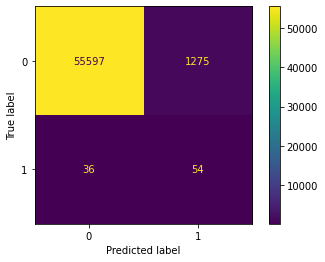

In [20]:
plot_confusion_matrix(treeClassifier, X_test, y_test)
plt.show()

(Nota aclaratoria: no confundir la precisión porcentual del modelo, calculada con el método score y que en inglés suele llamarse accuracy, con la precisión de la predicción de cada clase, calculada en el classification report, y que en inglés aparece como precision, sin tilde).

Bien, aunque pudiera parecer que es un buen modelo debido a su alta precisión porcentual, de más de 99,9%, en realidad esta medida no nos sirve de mucho, ya que está fuertemente influenciada por el desequilibrio muestral. Sí que nos son de más utilidad los valores de precision, recall y f1-score del report inferior, que no son tan buenos como podríamos esperar.

Para entenderlos mejor: tener un recall de 0.54 y una precision de 0.01 para la clase 1 que nuestro modelo es bastante malo. La f1-score se calcula con las dos medidas anteriores y como en ambos casos, su valor ideal sería de 1.
 
Nuestro modelo, por tanto, no es nada bueno a pesar de su 99,9% de precisión. Vamoso a probar a usar un modelo de random forest:

### Random forest

Seguimos una metodología similar a la usada en el modelo anterior. Como única nota, estoy usando un modelo con 40 modelos individuales porque, despueś de hacer varias pruebas, ese me ha parecido el mejor valor. A partir de ahí la mejora era despreciable.

In [21]:
forestClassifier = RandomForestClassifier(n_estimators = 40)
forestClassifier.fit(X_train, y_train.values.ravel())

forestScore = forestClassifier.score(X_test, y_test)
forestPredict = forestClassifier.predict(X_test)

print('La precisión del modelo es de', forestScore,
      '. A continuación se presentan su matriz de confusión y algunas estadísticas:\n', 
      confusion_matrix(y_test, forestPredict), '\n',classification_report(y_test, forestPredict))

La precisión del modelo es de 0.9990519995786665 . A continuación se presentan su matriz de confusión y algunas estadísticas:
 [[56866     6]
 [   48    42]] 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.88      0.47      0.61        90

    accuracy                           1.00     56962
   macro avg       0.94      0.73      0.80     56962
weighted avg       1.00      1.00      1.00     56962



El cambio de modelo a uno más complejo (el random forest se construye como un conjunto de varios decision trees) ha mejorado bastante nuestra precisión, que ha pasado de a ser de 0,82, nuestro modelo ya no tiene apenas falsos positivos. Sin embargo el recall sigue sin ser suficiente, aún se nos están escapando el 20% de operaciones fraudulentas, tenemos muchos falsos negativos.

### Regresión logística

Solo a modo ilustrativo voy a incluir un modelo de regresión logística para comparar:

In [22]:
logisticClassifier = linear_model.LogisticRegression(C=1e5, max_iter = 650)
logisticClassifier.fit(X_train, y_train.values.ravel())

logisticScore = logisticClassifier.score(X_test, y_test)
logisticPredict = logisticClassifier.predict(X_test)

print('La precisión del modelo es de', logisticScore,
      '. A continuación se presentan su matriz de confusión y algunas estadísticas:\n', 
      confusion_matrix(y_test, logisticPredict), '\n',classification_report(y_test, logisticPredict))

La precisión del modelo es de 0.9987008883115059 . A continuación se presentan su matriz de confusión y algunas estadísticas:
 [[56871     1]
 [   73    17]] 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.94      0.19      0.31        90

    accuracy                           1.00     56962
   macro avg       0.97      0.59      0.66     56962
weighted avg       1.00      1.00      1.00     56962



### XGBoost

La base de este modelo es que en lugar de funcionar con varios modelos indiviuales independientes, como un random forest, en el que cada submodelo toma una decisión por separado y luego se usa la decisión tomada más frecuentemente, XGBoost lo que hace es construir cada modelo sobre el anterior, reduciendo el error del mismo. Vamos a darle una oportunidad de detectar fraude.

In [23]:
boostClassifier = XGBClassifier()
boostClassifier.fit(X_train, y_train.values.ravel())

boostScore = boostClassifier.score(X_test, y_test)
boostPredict = boostClassifier.predict(X_test)

print('La precisión del modelo es de', boostScore,
      '. A continuación se presentan su matriz de confusión y algunas estadísticas:\n', 
      confusion_matrix(y_test, boostPredict), '\n',classification_report(y_test, boostPredict))

La precisión del modelo es de 0.9990519995786665 . A continuación se presentan su matriz de confusión y algunas estadísticas:
 [[56865     7]
 [   47    43]] 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.86      0.48      0.61        90

    accuracy                           1.00     56962
   macro avg       0.93      0.74      0.81     56962
weighted avg       1.00      1.00      1.00     56962



## Undersampling

A continuación, guardo en un array los índices de las transacciones fraudulentas, y en otro, la misma cantidad de índices de transacciones genuinas elegidos aleatoriamente de entre toda la muestra. Luego concateno ambos arrays y genero un dataframe a partir de la población original que contenga solo las subpoblaciones escogidas en esos arrays. Finalmente, le aplico a este nuevo dataframe las mismas operaciones que en el preprocesamiento de los datos originales:

In [24]:
inputData = pd.read_csv('creditcard.csv')
fraudIndexes = np.array(inputData[inputData['Class'] == 1].index)
genuineIndexes = np.array(np.random.choice(inputData[inputData['Class'] == 0].index, 492, replace = False))
undersamplingIndexes = np.concatenate([fraudIndexes, genuineIndexes])
undersampledData = inputData.iloc[undersamplingIndexes, :]

Una vez generado y procesado el nuevo dataset, lo separo como anteriormente en dos subsets, entrenamiento y validación:

In [25]:
underY = undersampledData[['Class']]
transUnderData = undersampledData.drop(['Time', 'Amount', 'Class'], axis = 1)
underX = transUnderData.iloc[:]

underX_training, underX_validation, underY_training, underY_validation = train_test_split(underX, underY, test_size = 0.2, random_state = 13)

In [26]:
dataColumns = transUnderData.columns
X_scaled = MinMaxScaler().fit_transform(underX_training)
underX_training = pd.DataFrame(data = X_scaled, columns = dataColumns)

In [27]:
dataColumns = transUnderData.columns
X_scaled = MinMaxScaler().fit_transform(underX_validation)
underX_validation = pd.DataFrame(data = X_scaled, columns = dataColumns)

### Random forest + undersampling

Volvemos a generar un modelo de random forest con los nuevos datos:

In [28]:
underForestClassifier = RandomForestClassifier(n_estimators = 40)
underForestClassifier.fit(underX_training, underY_training.values.ravel())

underForestScore = underForestClassifier.score(underX_validation, underY_validation)
underForestPredict = underForestClassifier.predict(underX_validation)

print('La precisión del modelo es de', underForestScore,
      '. A continuación se presentan su matriz de confusión y algunas estadísticas:\n', 
      confusion_matrix(underY_validation, underForestPredict), '\n',classification_report(underY_validation, underForestPredict))

La precisión del modelo es de 0.9137055837563451 . A continuación se presentan su matriz de confusión y algunas estadísticas:
 [[96 10]
 [ 7 84]] 
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       106
           1       0.89      0.92      0.91        91

    accuracy                           0.91       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.91      0.91      0.91       197



In [29]:
boostClassifier = XGBClassifier()
boostClassifier.fit(underX_training, underY_training.values.ravel())

boostScore = boostClassifier.score(underX_validation, underY_validation)
boostPredict = boostClassifier.predict(underX_validation)

print('La precisión del modelo es de', boostScore,
      '. A continuación se presentan su matriz de confusión y algunas estadísticas:\n', 
      confusion_matrix(underY_validation, boostPredict), '\n',classification_report(underY_validation, boostPredict))

La precisión del modelo es de 0.9289340101522843 . A continuación se presentan su matriz de confusión y algunas estadísticas:
 [[100   6]
 [  8  83]] 
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       106
           1       0.93      0.91      0.92        91

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

